In [2]:
import tensorflow as tf
conv_base = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib


new_base_dir = pathlib.Path('./datasets/catsvdogssmall/')

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Pass 3 arguments
1. ```weights```: specifies weight checkpoint from which to init model
2. ```include_top``` refers to including densely connected classifier of the network  
    i. default, densely connected classifier corresponds to 1000 classes from ImageNet  
    ii. because using own densely connected classifier (2 classes cats and dogs) don't need to include it  
3. ```input_shape``` shape of image tensors passed into network

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

We’ll start by extracting features as NumPy arrays by calling the predict() method of the conv_base model on our training, validation, and testing datasets.



In [4]:
# Extracting VGG16 features and corresponding labels
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [6]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 621ms/step


```predict()``` only expects images, not labels but current dataset yields batches that contain both images and labels.  
VGG16 expects inputs preprocessed with ```keras.applications.vgg16.preprocess_input``` which scales pixel values to appropriate range  

In [ ]:
train_features.shape

Can define densely connected classifier, train on data and labels recorded 

In [7]:
from tensorflow import keras 
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs) 
x = layers.Dense(256)(x)
# note use of dropout for regularization
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [8]:
model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 4s 52ms/step - loss: 14.2078 - accuracy: 0.9265 - val_loss: 3.8766 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 3s 52ms/step - loss: 4.5937 - accuracy: 0.9710 - val_loss: 11.5772 - val_accuracy: 0.9430
Epoch 3/20
63/63 [==============================] - 3s 48ms/step - loss: 2.1948 - accuracy: 0.9830 - val_loss: 4.6484 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 3s 47ms/step - loss: 0.9650 - accuracy: 0.9915 - val_loss: 11.3221 - val_accuracy: 0.9450
Epoch 5/20
63/63 [==============================] - 3s 51ms/step - loss: 1.0623 - accuracy: 0.9905 - val_loss: 4.5482 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 3s 52ms/step - loss: 0.4556 - accuracy: 0.9960 - val_loss: 3.9634 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 3s 52ms/step - loss: 0.4944 - accuracy: 0.9920 - val_loss: 7.0493 - val_accuracy: 0.9720
Epoch 8/20

THraining vwery fast because only have to deal with 2 dense layers

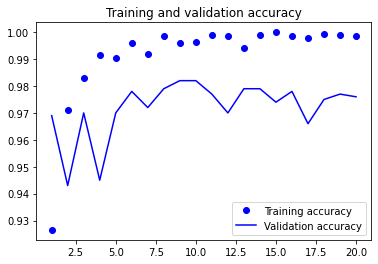

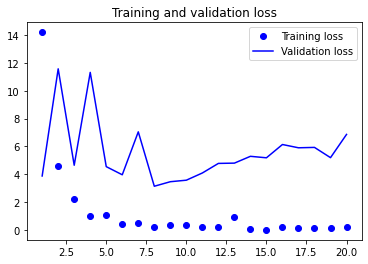

In [9]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the previous section with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the
task at hand. This won’t always be the case when you use pretrained features. However, the plots also indicate that we’re overfitting almost from the start—
despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image
datasets. 

### Feature Extraction with data augmentation
Freeze convolutional base  

In [11]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# empties list of trainable weights of the layer or model
conv_base.trainable = False

# print list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Create new model that chains together:
1. Data augmentation stage
2. Frozen convolutional base
3. Dense classifier

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [15]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

inputs = keras.Input(shape=(180, 180, 3))

# apply data augmentation
x = data_augmentation(inputs) 

# apply input value scaling
x = keras.applications.vgg16.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [16]:
history = model.fit(
    train_dataset,
    epochs = 50, 
    validation_data = validation_dataset,
    callbacks= callbacks
)

Epoch 1/50
 8/63 [==>...........................] - ETA: 2:34 - loss: 101.2791 - accuracy: 0.6953

KeyboardInterrupt: 

With this setup, only the weights from the two Dense layers that we added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). 

Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored. 

 Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50

## Fine Tuning
Slightly adjust more abstract representations of the model being reused to make them more relevent for current task

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.   
    i. (Note that you should not unfreeze “batch normalization” layers, which are not relevant 
        here since there are no such layers in VGG16.  
    ii. Batch normalization and its impact on fine tuning is explained in the next chapter.)
5. Jointly train both these layers and the part we added.

Steps 1 - 3 already done during feature extraction

Fine tune last 3 conv layers, freeze up to block4_pool

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Why not fine tune more layers?
1. Earlier layers encode more generic reusable features, later layers more specialized features. More useful to fine-tune more specialized features b/c these are ones to be repurposed on new problem  
2. More paramaters training, the more at risk of overfitting. Conv base has 15m parameters, risk to attempt to train on small dataset. 

Small dataset => good strategy to fine-tune top 2 or 3 layers in  conv base. 

In [18]:
# freeze everything up to last 4 layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [19]:
model.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]



In [20]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
 2/63 [..............................] - ETA: 3:32 - loss: 3.4426 - accuracy: 0.9375

KeyboardInterrupt: 